# test2p5.ipynb

A notebook to test the task of spinal_test_2 with an intermediate layer to help select the error signal.
See "A generalization of RGA, and Fourier components."

The task is the same as in spinal_test1.ipynb, but an am_oscillator(2D) is used in the M population.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

# PART 5
Using a layer of units with diffent delays for each motor unit.

In [1]:
%cd ../..
from draculab import *
import numpy as np

import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
def haar_matrix(dim):
    """ Returns an array with the normalized (2**dim x 2**dim) Haar matrix.
    
        Args:
            dim: an integer.
        Returns:
            A 2D numpy array of shape (2**dim, 2**dim), where each row is a
            Haar vector of norm 1.
    """
    # Obtain the matrix using the iterative procedure with Kronecker products
    h0 = np.array([1., 1.])
    h1 = np.array([1., -1.])
    haar = np.concatenate(([h0], [h1]))
    for d in range(1,dim):
        haar = np.concatenate((np.kron(haar, h0), 
                               np.kron(np.identity(2**d), h1)), axis=0)
    # Normalize the rows of the Haar matrix
    for idx, row in enumerate(haar):
        haar[idx, :] = row / np.linalg.norm(row)
    return haar

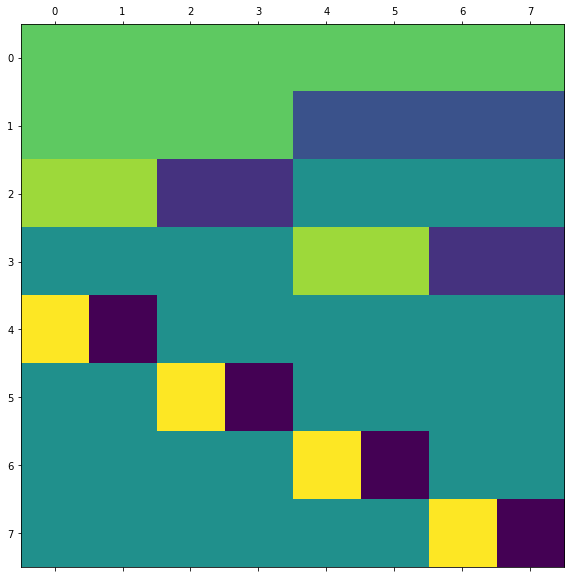

In [16]:
fig = plt.figure(figsize=(10,10))
plt.gca().matshow(haar_matrix(3))
#print(haar_matrix(3))
plt.show()

In [3]:
###################
#  Configuration  #
##################
N = 1 # size of each population
O_per_M = 4 # number of O units per M unit
t_pres = 40. # duration of each pattern presentation
M__P_type = 'identity' # type of M__P connections. See M__P_mats below
M_type = "am_pulse" # "am_pm", "am", "am2D", "am_pulse"
om_var = 1. # increases omega frequency heterogeneity
track_SPF__O_w = True # whether to track SPF__O weight for 1 O unit
track_O__M_w = True # whether to track O__M weight for 1 M(E|I) unit

In [4]:
#--------------------------------------------------------------

M__P_mats = {'identity' : 1.*np.eye(N),
             'haar' : haar_matrix(int(np.round(np.log(N)/np.log(2.)))),
             'overcomplete2' : np.random.random((N, 3*N))}
if N > 1:
    M__P_mats['overcomplete'] = np.concatenate((M__P_mats['identity'], M__P_mats['haar']), axis=1)
norms = np.linalg.norm(M__P_mats['overcomplete2'], axis=0)
M__P_mats['overcomplete2'] = M__P_mats['overcomplete2']/norms
W = M__P_mats[M__P_type]
M_N = W.shape[1]
O_N = M_N * O_per_M

des_pat = np.zeros(N) # desired pattern in SP
des_pats = np.random.random((2000, N)) # many desired patterns for SP
des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand(N)-0.5))

net_params = {'min_delay' : 0.001,
              'min_buff_size' : 10 }
# TODO : is it useful to keep these parameters around?
# GE_params = {'type' : unit_types.sigmoidal,
#              'thresh' : 0.4,
#              'slope' : 4.,
#              'tau' : 0.02,
#              'tau_fast': 0.05,
#              'tau_mid' : 1.,
#              'delay' : 0.3,
#              'extra_requirements' : ['lpf_fast', 'lpf_mid'],
#              'init_val' : 0.2 }

if M_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    M_syn_type = unit_types.am_pm_oscillator
elif M_type == "am2D":
    init_base = np.array([0.5, 0.5])
    M_syn_type = unit_types.am_oscillator2D
elif M_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    M_syn_type = unit_types.am_pulse
elif M_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    M_syn_type = unit_types.am_oscillator 
M_params = {'type' : M_syn_type,
            'integ_meth' : 'odeint',
            'tau_u' : 0.05,
            'tau_c' : .1, # originally 0.2
            'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
            'multidim' : True,
            'n_ports' : 3,
            'omega' : 1.*np.pi,
            #'custom_inp_del' : 200,
            'tau_fast': 0.01,
            'tau_mid' : 0.1,
            'tau_slow' : 1.,
            'delay' : 0.24,
            'extra_requirements' : ["lpf_fast", "lpf_mid"], # for gated_diff_inp_corr
            'A' : 1.,
            'mu' : 0.,
            'sigma' : 0.0 }
O_params = {'type' : unit_types.inpsel_linear2,
            'init_val' : 0.,
            'xtra_inp_del' : 0.1, # placeholder value
            'tau_fast': 0.01,
            'tau_mid' : 0.1,
            'tau_slow' : 1.5,
            'tau' : 0.02,
            'extra_requirements' : ["lpf_fast", "lpf_mid"] }
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }#* randz() }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0. * randz(),
             'slope' : 1. * randz(),
             'init_val' : 0.2 * randz(),
             'tau' : 0.05 }#* randz() }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.3 * randz(), # 0.5 originally
              'slope' : 6. * randz(),  # 4. originally
              'delay' : 0.3,
              'init_val' : 0.3 * randz(),
              'tau_fast': 0.01, # 0.005
              'tau_mid': 0.2,  # 0.05
              'tau_slow' : 10., # 5
              'tau' : 0.05, #* randz(),
              'des_out_w_abs_sum' : 2. }
SPF2_params = SPF1_params

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base angular (rad/s)
            r : amplitude of noise
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
                    'freqs[i]' will be the angular frequency of M[i].
            steps : a list with the corresponding delays.
                    'steps[i]' will contain the min_delay steps for the delay
                    of the SPF activity with respect to the M activity arriving
                    at the O unit receiving input from M[i].
    """
    ws = w + r*(np.random.random(n) - 0.5)
    #ws = ws / M_params['tau_t'] # angular frequencies
    #om_del = np.arctan(M_params['tau_c']*ws)/ws # c responds to input
    mp_del = np.arctan(P_params['tau']*ws)/ws
    psf_del = np.arctan(SF_params['tau']*ws)/ws
    sfspf_del = np.arctan(SPF1_params['tau']*ws)/ws
    d1 = mp_del + psf_del + sfspf_del + 3.*0.02
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

# creating units
net = network(net_params)
#GE = net.create(1, GE_params) # no use for this right now
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)

omegasE, del_stepsE = create_freqs_steps(M_N, 1.1*M_params['omega'], om_var)
omegasI, del_stepsI = create_freqs_steps(M_N, 0.9*M_params['omega'], om_var)

adsE = int(np.round(sum(del_stepsE)/len(del_stepsE))) # average ME-SPF delay for the ME oscillators              
adsI = int(np.round(sum(del_stepsI)/len(del_stepsI))) # average MI-SPF delay  for the MI oscillators
ads = int((adsE+adsI)/2)
OE = [] # OE[i] = list with ID's of i-th ME unit
OI = [] # OI[i] = list with ID's of i-th MI unit
advE = int(adsE/3) # how much smaller the earliest O unit's delay will be
advI = int(adsI/3)
for n in range(M_N):
    O_params['xtra_inp_del'] = [del_stepsE[n]-advE-20]*O_per_M
    OE.append(net.create(O_per_M, O_params))
    O_params['xtra_inp_del'] = [del_stepsI[n]-advI-20]*O_per_M
    OI.append(net.create(O_per_M, O_params))      
OE_flat = [i for sublist in OE for i in sublist]
OI_flat = [i for sublist in OI for i in sublist]
    
M_params['delay'] = net_params['min_delay'] * (2*max(del_stepsE)+2-advE)
M_params['omega'] = omegasE
ME = net.create(M_N, M_params)
M_params['delay'] = net_params['min_delay'] * (2*max(del_stepsI)+2-advI)
M_params['omega'] = omegasI
MI = net.create(M_N, M_params)

# set the pattern in SP
def make_fun(idx):
    #return lambda t: des_pat[idx]
    return lambda t: des_pats[int(round(t/t_pres)),idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# Create the connections. 

# lateral connections in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : -0.01/N }
ME__MI_conn = {'rule': 'one_to_one',
               'delay' : 0.02 }
ME__MI_syn = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -0.8 } # -0.5 }
MI__ME_conn = ME__MI_conn
MI__ME_syn = ME__MI_syn
MI__MI_conn = ME__ME_conn
MI__MI_syn = ME__ME_syn

# ME/MI to O connections (with a range of delays)
M__O_dels = list(0.02 + net_params['min_delay']*
                 (np.round(np.linspace(0.,1.,O_per_M) * ads).astype(int) + 1))
M__O_conn = {'rule' : 'all_to_all',
              'delay' : M__O_dels }
M__O_syn = {'type' : synapse_types.static,
             'inp_ports' : 2,
             'init_w' : 1. }

# connect ME/MI to P
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static_l0_normal,
             'w_sum' : 2.,
             'tau_norml' : 5.,
             'init_w' : W.flatten() }
MI__P_conn = ME__P_conn
MI__P_syn = {'type': synapse_types.static_l0_normal,
             'w_sum' : 2.,
             'tau_norml' : 5.,
             'init_w' : -W.flatten() }

# O__M connections
O__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
O__M_syn = {'type' : synapse_types.comp_pot,
            'inp_ports' : 0,
            'tau_norml' : 0.2,
            'w_sum' : 1.,
            'lrate' : 10.,
            'init_w' : 1./O_per_M }

# O__O connections (lateral inhibition)
O__O_conn = {'rule' : 'all_to_all',
             'allow_autapses' : False,
             'delay' : 0.02}
O__O_syn = {'type' : synapse_types.static,
            'inp_ports' : 1,
            'init_w' : -1. / O_per_M}

# From P to SF
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }

SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = SF__SPF1_conn
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = SP__SPF1_conn
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }

SPF1__OE_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__OE_conn = SPF1__OE_conn
SPF1__OI_conn = SPF1__OE_conn
SPF2__OI_conn = SPF1__OE_conn
SPF1__OE_syn = {'type' : synapse_types.gated_diff_inp_corr,
                'lrate': 50.,
                'inp_ports': 0,
                'asc_port' : 2,
                'error_port' : 0,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }       
SPF2__OE_syn = SPF1__OE_syn
SPF1__OI_syn = SPF1__OE_syn
SPF2__OI_syn = SPF1__OI_syn

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, OE_flat, SPF1__OE_conn, SPF1__OE_syn)
net.connect(SPF1, OI_flat, SPF1__OI_conn, SPF1__OI_syn)
net.connect(SPF2, OE_flat, SPF2__OE_conn, SPF2__OE_syn)
net.connect(SPF2, OI_flat, SPF2__OI_conn, SPF2__OI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

for idx in range(M_N):
    # M__O
    net.connect([ME[idx]], OE[idx], M__O_conn, M__O_syn)
    net.connect([MI[idx]], OI[idx], M__O_conn, M__O_syn)
    # O__M
#     net.connect(OE[idx], [ME[idx]], O__M_conn, O__M_syn)
#     net.connect(OI[idx], [MI[idx]], O__M_conn, O__M_syn)
    net.connect(OE[idx], [MI[idx]], O__M_conn, O__M_syn)
    net.connect(OI[idx], [ME[idx]], O__M_conn, O__M_syn)
    # O__O
    net.connect(OE[idx], OE[idx], O__O_conn, O__O_syn)
    net.connect(OI[idx], OI[idx], O__O_conn, O__O_syn)
    
# tracking state variables of the oscillator
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
def create_state_track(uid, var_id):
    return lambda t: net.units[uid].buffer[var_id,-1]
if M_type == "am":
    n_track = 3
elif M_type == "am2D" or M_type == "am_pulse":
    n_track = 2
elif M_type == "am_pm":
    n_track = 4
M_track = net.create(n_track, track_params)
for var in range(n_track):
    net.units[M_track[var]].set_function(create_state_track(ME[0],var))
    
if track_SPF__O_w:
    # tracking SPF__OE[0] weights
    SPF__O_track = net.create(2*N*O_per_M, track_params)
    SPF__O_syns = [[syn for syn in net.syns[OE[0][idx]] if syn.port == SPF1__OE_syn['inp_ports']] for idx in range(O_per_M)]
    def SPF__O_fun(spf_idx, o_idx):
        """ Creates a function to track a weight from SPF to OE. """
        return lambda t: SPF__O_syns[o_idx][spf_idx].w
    for spf_idx in range(len(SPF1+SPF2)):
        for o_idx in range(O_per_M):
            net.units[SPF__O_track[2*N*o_idx + spf_idx]].set_function(SPF__O_fun(spf_idx,o_idx))
        
if track_O__M_w:
    O__M_track = net.create(O_per_M, track_params)
    oe_idxs = [syn.preID for syn in net.syns[ME[0]] if syn.preID in OE_flat]
    def O__M_fun(idx):
        return lambda t: net.syns[ME[0]][idx].w
    for idx, oe_idx in enumerate(oe_idxs):
        net.units[O__M_track[idx]].set_function(O__M_fun(idx))
        
#TODO: chg unit resets acc_slow

In [5]:
sim_time = 100.
start_time = time.time()
times, data, _  = net.flat_run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 204.9654049873352 seconds


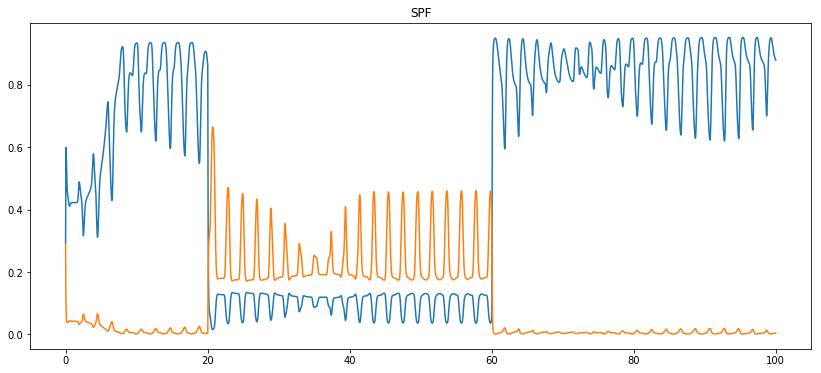

[0.87818704 0.00442753]


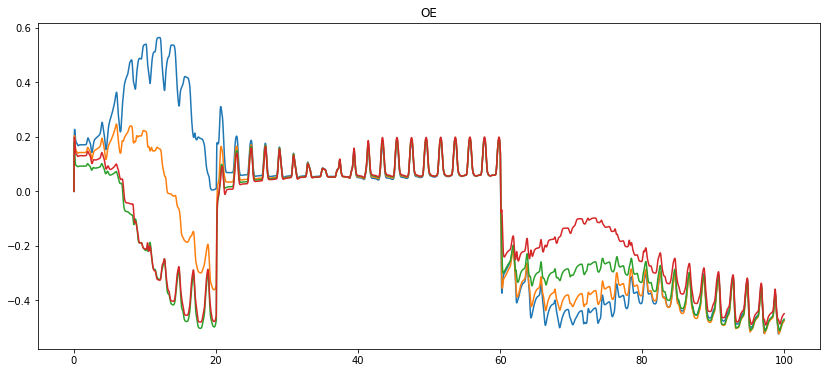

[-0.47317527 -0.47514314 -0.46880105 -0.4489569 ]


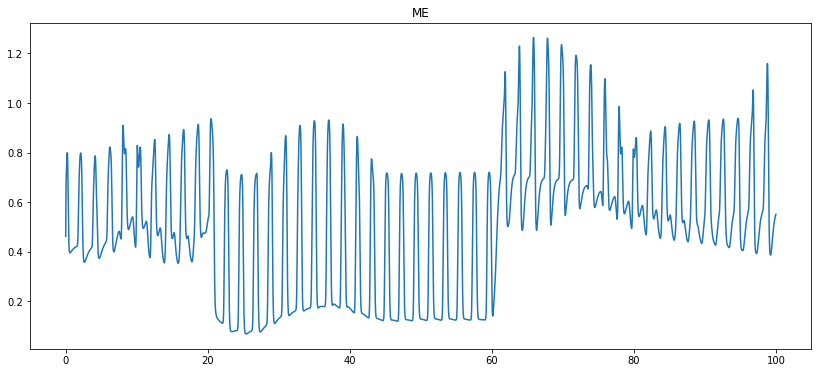

[0.55098838]


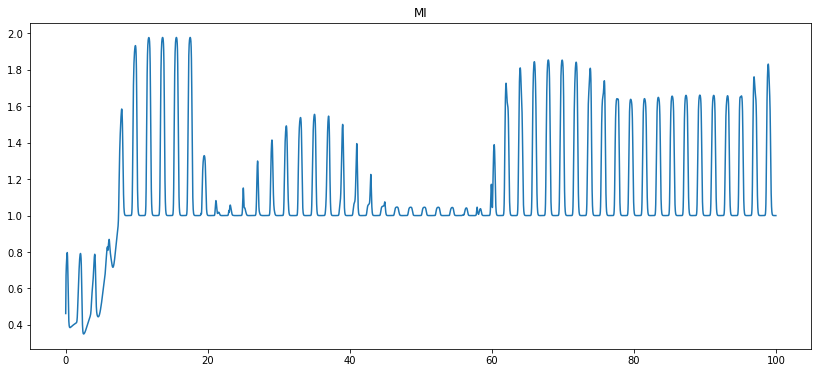

[1.00000037]


In [6]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# OE
OE_fig = plt.figure(figsize=fs)
OE_data = np.array(data[OE[0]])
plt.plot(times, OE_data.transpose())
plt.title('OE')
plt.show()
print(OE_data[:,-1])

# M
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])



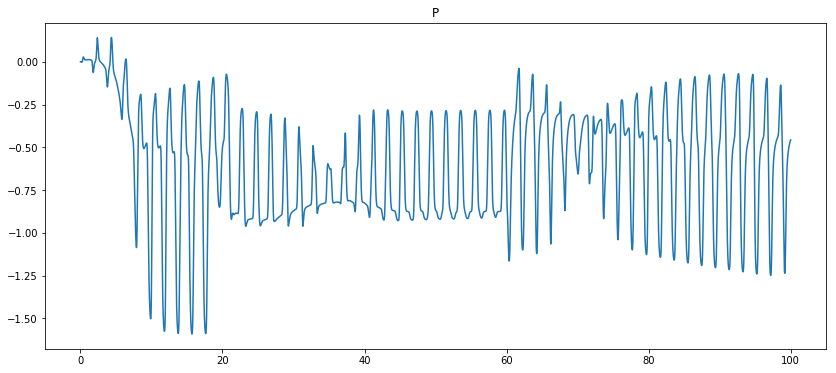

[-0.45688254]


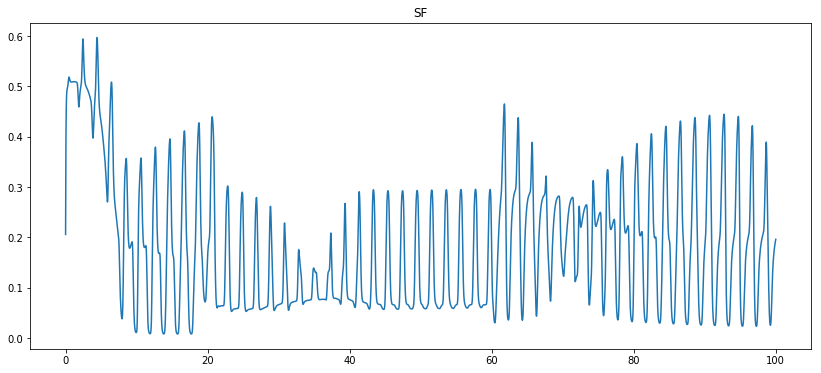

[0.19622128]
[0.81288653]


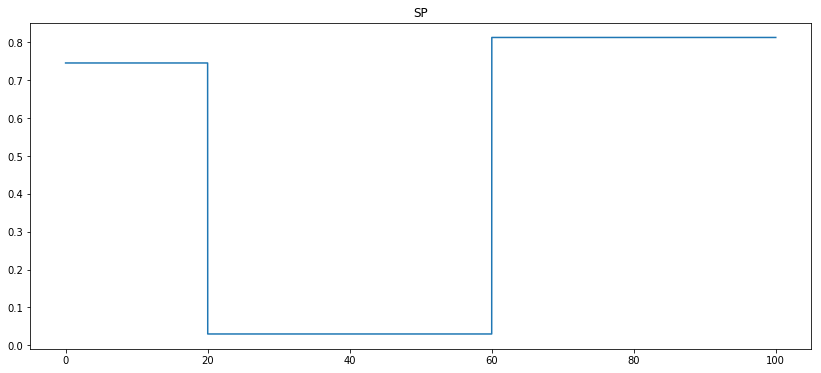

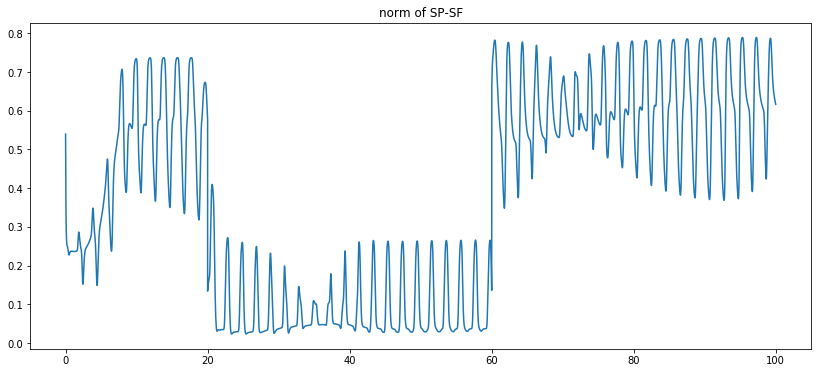

In [7]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


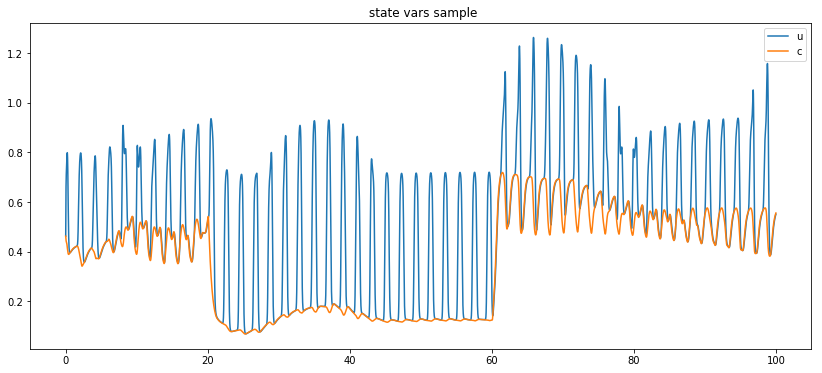

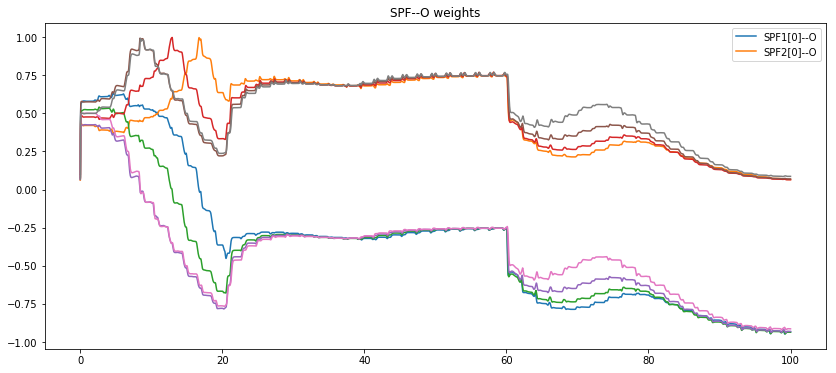

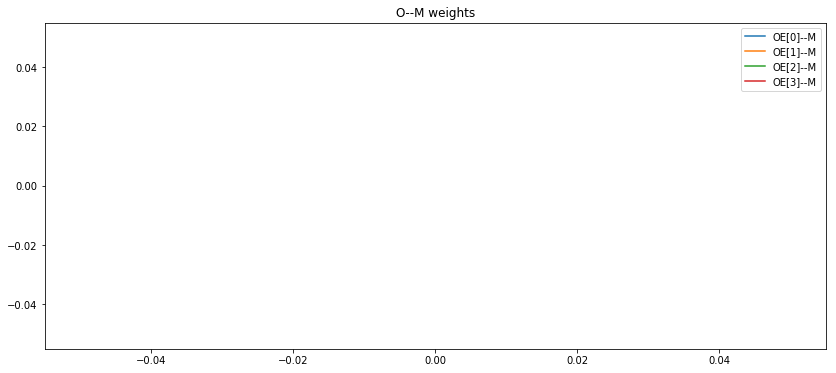

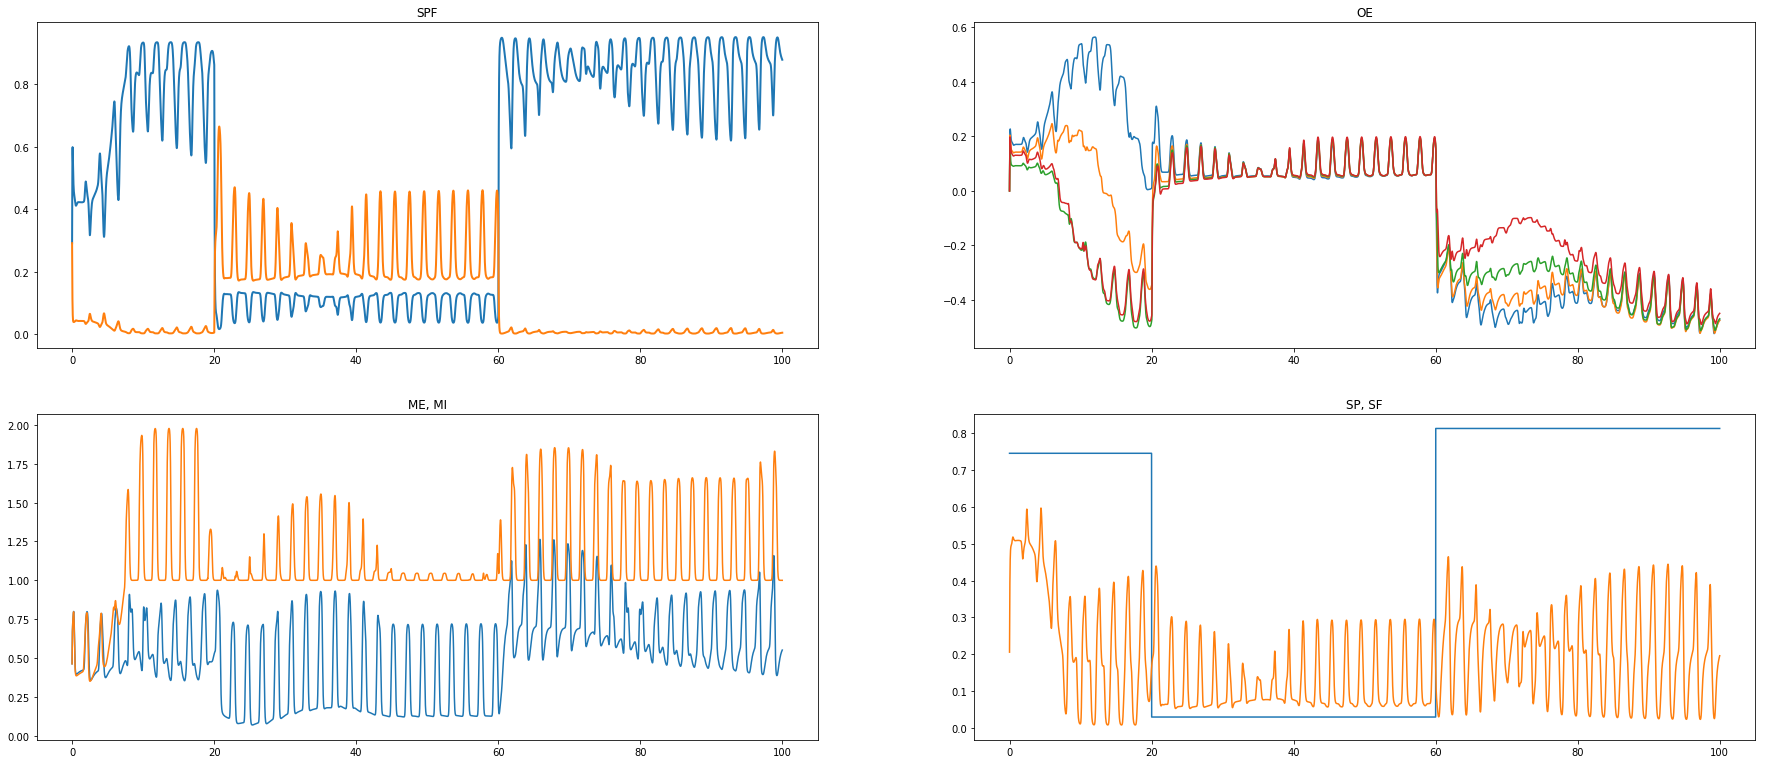

In [8]:
# state var trackers
M_track_fig = plt.figure(figsize=fs)
track_data = np.array(data[M_track])
plt.plot(times, data[M_track[0]])
plt.plot(times, data[M_track[1]])
if M_type == "am":
    plt.plot(times, data[M_track[2]])
elif M_type == "am_pm":
    plt.plot(times, data[M_track[3]])
if M_type == "am2D":
    plt.legend(['u','c'])
else:
    plt.legend(['u','c','I'])
#plt.plot(times, track_data.trose())
#plt.plot(times, data[ME[0],:],'r')
plt.title(' state vars sample')

# weight tracking
W_fig1 = plt.figure(figsize=fs)
w_track_data1 = np.array(data[SPF__O_track[0:N]])
w_track_data2 = np.array(data[SPF__O_track[N:]])
plt.plot(times, w_track_data1.transpose())
SPF__O_legends1 = ['SPF1['+str(i)+']--O' for i in range(N)]
plt.plot(times, w_track_data2.transpose())
SPF__O_legends2 = ['SPF2['+str(i)+']--O' for i in range(N)]
plt.legend(SPF__O_legends1+SPF__O_legends2)
plt.title('SPF--O weights')

if track_O__M_w:
    W_fig2 = plt.figure(figsize=fs)
    w_track_data3 = np.array(data[O__M_track])
    plt.plot(times, w_track_data3.transpose())
    O__M_legends = ['OE['+str(i)+']--M' for i in range(O_per_M)]
    plt.legend(O__M_legends)
    plt.title('O--M weights')
    
if track_O__M_w:
    O__M_track

# joint plot
joint_fig, axs = plt.subplots(2, 2, figsize=(2.2*fs[0], 2.2*fs[1]))
axs[0][0].plot(times, SPF_data.transpose(), linewidth=2)
axs[0][0].set_title('SPF')
axs[0][1].plot(times, OE_data.transpose())
axs[0][1].set_title('OE')
axs[1][0].plot(times, ME_data.transpose())
axs[1][0].plot(times, MI_data.transpose())
axs[1][0].set_title('ME, MI')
axs[1][1].plot(times, SP_data.transpose())
axs[1][1].plot(times, SF_data.transpose())
axs[1][1].set_title('SP, SF')

plt.show()

In [9]:
print([syn.delay_steps for syn in net.syns[OE[0][0]]])
for syn in net.syns[OE[0][0]]:
    print(syn.type.name)
    print("(%d)-->(%d)"%(syn.preID,syn.postID))

[20, 20, 21, 20, 20, 20]
gated_diff_inp_corr
(2)-->(5)
gated_diff_inp_corr
(3)-->(5)
static
(13)-->(5)
static
(6)-->(5)
static
(7)-->(5)
static
(8)-->(5)


In [10]:
m_id = 0
for idx, syn in enumerate(net.syns[ME[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in OE_flat:
        pre_pop = 'OE'
    elif pre_id in OI_flat:
        pre_pop = 'OI'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME[%d], w=%f, port=%d, utype=%s, syn_type=%s'
          %(idx, pre_pop, pre_id, m_id, syn.w, syn.port, pre_type.name, syn.type.name))

0) MI (14) --> ME[0], w=-0.800000, port=1, utype=am_pulse, syn_type=static
1) OI (9) --> ME[0], w=0.995096, port=0, utype=inpsel_linear2, syn_type=comp_pot
2) OI (10) --> ME[0], w=0.000000, port=0, utype=inpsel_linear2, syn_type=comp_pot
3) OI (11) --> ME[0], w=0.000000, port=0, utype=inpsel_linear2, syn_type=comp_pot
4) OI (12) --> ME[0], w=0.000000, port=0, utype=inpsel_linear2, syn_type=comp_pot


In [11]:
m_id = 0
for idx, syn in enumerate(net.syns[MI[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in OE_flat:
        pre_pop = 'OE'
    elif pre_id in OI_flat:
        pre_pop = 'OI'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI[%d], w=%f, port=%d, utype=%s, syn_type=%s'
          %(idx, pre_pop, pre_id, m_id, syn.w, syn.port, pre_type.name, syn.type.name))

0) ME (13) --> MI[0], w=-0.800000, port=1, utype=am_pulse, syn_type=static
1) OE (5) --> MI[0], w=0.988049, port=0, utype=inpsel_linear2, syn_type=comp_pot
2) OE (6) --> MI[0], w=0.000000, port=0, utype=inpsel_linear2, syn_type=comp_pot
3) OE (7) --> MI[0], w=0.000000, port=0, utype=inpsel_linear2, syn_type=comp_pot
4) OE (8) --> MI[0], w=0.000000, port=0, utype=inpsel_linear2, syn_type=comp_pot


In [12]:
m_unit = 0
for oe_id, post_id in enumerate(OE[m_unit]):
    print("for OE[%d][%d]"%(m_unit, oe_id))
    for idx, syn in enumerate(net.syns[post_id]):
        pre_id = syn.preID
        pre_type = net.units[pre_id].type
        if pre_id in P:
            pre_pop = 'P'
        elif pre_id in OE_flat:
            pre_pop = 'OE'
        elif pre_id in SPF1:
            pre_pop = 'SPF1'
        elif pre_id in SPF2:
            pre_pop = 'SPF2'
        elif pre_id in ME:
            pre_pop = 'ME'
        elif pre_id in MI:
            pre_pop = 'MI'
        elif pre_id in OI_flat:
            pre_pop = 'OI'
        else:
            pre_pop = 'other'
        
        print('%d) %s (%d) --> OE[%d], w=%f, port=%d, utype=%s, syn_type=%s'
          %(idx, pre_pop, pre_id, m_id, syn.w, syn.port, pre_type.name, syn.type.name))
    print('\n')
    

for OE[0][0]
0) SPF1 (2) --> OE[0], w=-0.934298, port=0, utype=out_norm_sig, syn_type=gated_diff_inp_corr
1) SPF2 (3) --> OE[0], w=0.066006, port=0, utype=out_norm_sig, syn_type=gated_diff_inp_corr
2) ME (13) --> OE[0], w=1.000000, port=2, utype=am_pulse, syn_type=static
3) OE (6) --> OE[0], w=-0.250000, port=1, utype=inpsel_linear2, syn_type=static
4) OE (7) --> OE[0], w=-0.250000, port=1, utype=inpsel_linear2, syn_type=static
5) OE (8) --> OE[0], w=-0.250000, port=1, utype=inpsel_linear2, syn_type=static


for OE[0][1]
0) SPF1 (2) --> OE[0], w=-0.935969, port=0, utype=out_norm_sig, syn_type=gated_diff_inp_corr
1) SPF2 (3) --> OE[0], w=0.064386, port=0, utype=out_norm_sig, syn_type=gated_diff_inp_corr
2) ME (13) --> OE[0], w=1.000000, port=2, utype=am_pulse, syn_type=static
3) OE (5) --> OE[0], w=-0.250000, port=1, utype=inpsel_linear2, syn_type=static
4) OE (7) --> OE[0], w=-0.250000, port=1, utype=inpsel_linear2, syn_type=static
5) OE (8) --> OE[0], w=-0.250000, port=1, utype=inpsel

In [13]:
for i in range(O_per_M):
    print([syn.delay_steps for syn in net.syns[OE[0][i]]])

[20, 20, 21, 20, 20, 20]
[20, 20, 91, 20, 20, 20]
[20, 20, 160, 20, 20, 20]
[20, 20, 230, 20, 20, 20]


In [15]:
[net.units[uid].pre_uid_del_mp for uid in OE[0]]

[[([], []), ([], []), ([13], [21]), ([], [])],
 [([], []), ([], []), ([13], [91]), ([], [])],
 [([], []), ([], []), ([13], [160]), ([], [])],
 [([], []), ([], []), ([13], [230]), ([], [])]]

In [15]:
[net.units[uid].xtra_del_inp_deriv_mp for uid in OE[0]]

[[[], [], [0.0027143987227082333], []],
 [[], [], [0.0024249418582231175], []],
 [[], [], [0.0015819175153851672], []],
 [[], [], [-0.00034386794433932666], []]]

In [16]:
[net.units[uid].xtra_del_inp_deriv_mp_sc_sum for uid in OE[0]]

[[0, 0, 0.002712651147415257, 0],
 [0, 0, 0.0024176954520552796, 0],
 [0, 0, 0.001563696228539968, 0],
 [0, 0, -0.0003831771566190634, 0]]

In [17]:
print(net.units[OE[0][0]].mp_weights)
print(net.units[OE[0][0]].xtra_del_inp_deriv_mp, end='\n\n')
print(net.units[OE[0][0]].xtra_del_inp_deriv_mp_sc_sum)
print([net.syns[OE[0][0]][0].asc_port, net.syns[OE[0][0]][0].error_port])

[array([0.43877846, 0.56122154]), array([-0.25, -0.25, -0.25]), array([1.]), array([], dtype=float64)]
[[], [], [0.0027143987227082333], []]

[0, 0, 0.002712651147415257, 0]
[2, 0]


In [14]:
u = net.units[MI[0]]
u.omega

3.141592653589793

In [33]:
[sum([w_l[idx]*ddiff_l[idx] for idx in range(len(ddiff_l))]) for w_l,ddiff_l in zipla]

[0, 0, -0.10305532485019303, 0]